In [1]:
import re
import pandas as pd
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from datetime import datetime
import warnings

from scipy import stats 
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from scipy.stats import f_oneway

# Primary Dataset

The primary dataset consists of debates from the Hansard archive of the House of Commons that have "nuclear waste" or "radioactive waste" in their titles.

Upon it, we will perform a VAD analysis, as well as statistically validating that result. 

Our first step will be to clean and process the raw text files.

## Processing and Cleaning

In [2]:
# So, what we're going to do now is extract the paragraphs from each debate as described in the methods section.
# This should be simple enough so we shall crack on. 

def save_paragraph_society(text, filename):
    politicians_and_their_lines = text.strip().split('\n') # First, we need to actually remove the blank spaces which are kinda useless to us. Lest you want to analyse actual empty space (more substantial than the words of a politician mayhaps)
    
    # Now, we can extract the date of the debate the paragraphs come from by simply using the date in the filename
    omg_date_match = re.search(r'(\d{4}-\d{2}-\d{2})', filename)
    sugoi_valentines_date = omg_date_match.group(1) if omg_date_match else "Unknown"
    
    # And the title can be found in the first line of EVERY Hansard debate
    title = politicians_and_their_lines[0].strip()
    title = re.sub(r'\s*\d{4}-\d{2}-\d{2}$', '', title).strip()

    # Two empty lists, one for finality, one for processing. These paragraphs will make a fine addition to my collection. 
    paragraphs = [] 
    current_paragraph = []
    
    # Right, now we need to skip the title as it's not actually relevant to analysis
    for line in politicians_and_their_lines[1:]:
        line = line.strip()
        
        # Empty lines should be skipped
        if not line:
            # If the paragraph has actual content, we need to make it a fine addition to our collection. 
            if current_paragraph:
                paragraph_text = '\n'.join(current_paragraph).strip()
                if paragraph_text and len(paragraph_text.split()) > 3:  # This will prevent us from taking paragraphs which are literally "hear, hear!" (I HATE the Commons)
                    paragraphs.append({
                        'paragraph': paragraph_text,
                        'debate_title': title,
                        'date': sugoi_valentines_date,
                    })
                current_paragraph = []
            continue
        
        # This will help us find lines that are just timestamps (common in Hansard debates) and skip them
        if re.match(r'^\d{1,2}\.\d{2}\s*(?:am|pm)?$', line):
            continue
        
   # Now, sometimes, before each paragraph, it has the name of the speaker
        # Now originally, I wanted to use this to create a speaker column
        # But it was just too complicated so I just decided to skip them
        if (len(line.split()) <= 6 and # Less than six words, aka, likely a line that just has a name (considering the rest function as continuous paragraphs) 
            (re.match(r'^[A-Z][a-z]+ [A-Z]', line) or  # This follows the naming pattern
             re.match(r'^(Mr|Mrs|Ms|Dr|Sir|Lord|Lady|The)', line)) ):  # Common Titles associated with people or politics
            continue
        
        # Everything else is paragraph content
        current_paragraph.append(line)
    
    # Last paragraph doesn't have a blank space after it so we need to account for it
    if current_paragraph:
        john_paragraph_text = '\n'.join(current_paragraph).strip()
        if john_paragraph_text and len(john_paragraph_text.split()) > 3: # Prevents hear hear nonsense again
            paragraphs.append({
                'paragraph': john_paragraph_text,
                'debate_title': title,
                'date': sugoi_valentines_date,
            })
    
    return paragraphs

# Now, we make a function to do that to every text file and put it into one nice ol dataframe
def process_the_debate_files_rhymes_with_grug(folder_path):
    all_paragraphs = []
    
    # Grabs all the text files
    txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    
    for filename in txt_files:
        file_path = os.path.join(folder_path, filename)
        
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()

            debate_paragraphs = save_paragraph_society(content, filename)
            all_paragraphs.extend(debate_paragraphs)
            title = debate_paragraphs[0]['debate_title'] if debate_paragraphs else 'Unknown'
            
            print(f"The {title} debate has made a fine addition to our collection with {len(debate_paragraphs)} paragraphs") # This will tell us how many paragraphs are extracted from each Hansard debate
            print()
            
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}") # This is necessary as we have a load of paragraphs and need to know if one goes wrong
            
    df = pd.DataFrame(all_paragraphs)  
    
    # This will add a paragraph_id, just in case we need to identify a paragraph more easily (because one debate will have multiple paragraphs)
    if not df.empty:
        df['paragraph_id'] = range(len(df))
    
    return df

In [3]:
# Now we execute our function and voila! Complete dataframe
df = process_the_debate_files_rhymes_with_grug('files')
df.set_index('paragraph_id', inplace=True)
df

The Nuclear Waste Store (Torness And Hunterston) debate has made a fine addition to our collection with 51 paragraphs

The Nuclear Waste (Scotland) debate has made a fine addition to our collection with 50 paragraphs

The Nuclear Waste debate has made a fine addition to our collection with 14 paragraphs

The Nuclear Waste Disposal debate has made a fine addition to our collection with 4 paragraphs

The Nuclear Waste (Disposal) debate has made a fine addition to our collection with 90 paragraphs

The Nuclear Waste (Transport) debate has made a fine addition to our collection with 48 paragraphs

The Nuclear Waste debate has made a fine addition to our collection with 6 paragraphs

The Nuclear Waste (Sellafield) debate has made a fine addition to our collection with 30 paragraphs

The Nuclear Waste Disposal debate has made a fine addition to our collection with 9 paragraphs

The Nuclear Waste Disposal (Loch Doon) debate has made a fine addition to our collection with 53 paragraphs

The Nu

,paragraph,debate_title,date
paragraph_id,,,
0,"I seem to recall, Mr. Deputy Speaker, that you...",Nuclear Waste Store (Torness And Hunterston),1992-07-09
1,I am grateful for this opportunity to debate t...,Nuclear Waste Store (Torness And Hunterston),1992-07-09
2,There has been remarkably little public debate...,Nuclear Waste Store (Torness And Hunterston),1992-07-09
3,I stress that my comments about the lack of pu...,Nuclear Waste Store (Torness And Hunterston),1992-07-09
4,I put a parliamentary question to the Secretar...,Nuclear Waste Store (Torness And Hunterston),1992-07-09
...,...,...,...
2919,I thank right hon. and hon. Members for their ...,Draft Transfrontier Shipment of Radioactive Wa...,2019-01-22
2920,I endorse what my right hon. Friend the Member...,Draft Transfrontier Shipment of Radioactive Wa...,2019-01-22
2921,I reassure the Scottish National party spokesm...,Draft Transfrontier Shipment of Radioactive Wa...,2019-01-22


## VAD Analysis

Now, the next step as described by the methods is to actually perform our VAD analysis. This will be done using the NLP methods taught in the NLP module, where we shall tokenise the text and then use the vad.xlsx file to assign each paragraph an average VAD score. 

In [4]:
# First, we need to gather the tools that will actually facilitate our tokenisation of the text. 
lemmatizer = WordNetLemmatizer()
stops = set(stopwords.words('english'))
punct = set(string.punctuation)

# Right, now we need to get rid of our stop words and punctuation, convert to a dictionary, and then we can actually process it for VAD
def act_like_an_angel_preprocess_like_crazy(text):
    if pd.isna(text) or text == "":
        return []
    tokens = word_tokenize(str(text).lower())
    clean_tokens = [lemmatizer.lemmatize(token) for token in tokens 
                   if token not in punct and token not in stops and token.isalpha()]
    return clean_tokens

# And this is our VAD function
def mr_john_vad(text, vad_lexicon):

    tokens = act_like_an_angel_preprocess_like_crazy(text)
    
    valence_scores = []
    arousal_scores = []
    dominance_scores = []
    matched_words = [] # words that are actually in the VAD lexicon, so we can use them below

    # Gets the VAD score, and also if it DOESN'T have a VAD score then it triggers a KeyError
    for jrr_token in tokens:
        if jrr_token in vad_lexicon.index:
            try:
                valence_scores.append(vad_lexicon.loc[jrr_token, 'valence'])
                arousal_scores.append(vad_lexicon.loc[jrr_token, 'arousal'])
                dominance_scores.append(vad_lexicon.loc[jrr_token, 'dominance'])
                matched_words.append(jrr_token)
            except KeyError:    
                cols = vad_lexicon.columns.tolist()
                if len(cols) >= 3:
                    valence_scores.append(vad_lexicon.loc[jrr_token, cols[0]])
                    arousal_scores.append(vad_lexicon.loc[jrr_token, cols[1]])
                    dominance_scores.append(vad_lexicon.loc[jrr_token, cols[2]])
                    matched_words.append(jrr_token)

    # The below calculates the average VAD score, or in the case there is no VAD, in which case it will return NaN
    if len(valence_scores) > 0:
        return {
            'valence': np.mean(valence_scores),
            'arousal': np.mean(arousal_scores),
            'dominance': np.mean(dominance_scores),
            'matched_words': len(valence_scores),
            'total_words': len(tokens)
        }
    else:
        return {
            'valence': np.nan,
            'arousal': np.nan,
            'dominance': np.nan,
            'matched_words': 0,
            'total_words': len(tokens)
        }

# Now we need to convert the date column into computable dates, as well as group rows in 5 year periods for analysis (as mentioned in the methods section)
def if_i_could_put_time_in_a_vad_dataframe(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['five_year_bin'] = (df['year'] // 5) * 5  

    # This ensures the right averages are actually being assigned to the right 5 year periods
    vad_columns = [col for col in df.columns if col in ['valence', 'arousal', 'dominance']]
    
    if vad_columns:
        yearly_vad = df.groupby('year')[vad_columns].mean()
        five_year_vad = df.groupby('five_year_bin')[vad_columns].mean()
    else:
        yearly_vad = pd.DataFrame()
        five_year_vad = pd.DataFrame()
    
    return yearly_vad, five_year_vad

In [5]:
# Now, we actually execute our functions and we can have a dataframe with VAD scores assigned to each paragraph
vad_lexicon = pd.read_excel('vad.xlsx', index_col=0)

df[['valence', 'arousal', 'dominance', 'matched_words', 'total_words']] = df['paragraph'].apply(
    lambda x: pd.Series(mr_john_vad(x, vad_lexicon))
)

yearly_vad, five_year_vad = if_i_could_put_time_in_a_vad_dataframe(df)

## Visualising the Results

Now, the first thing we are going to do is plot the results for our VAD changes over time

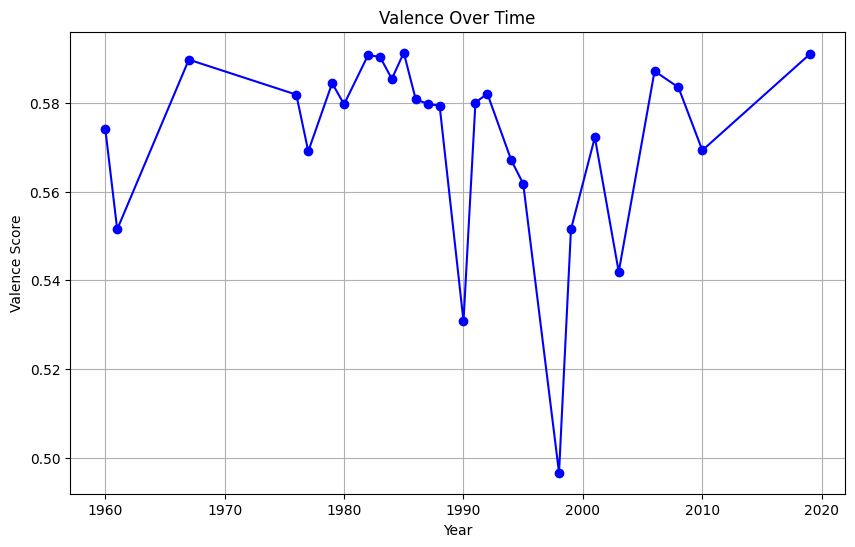

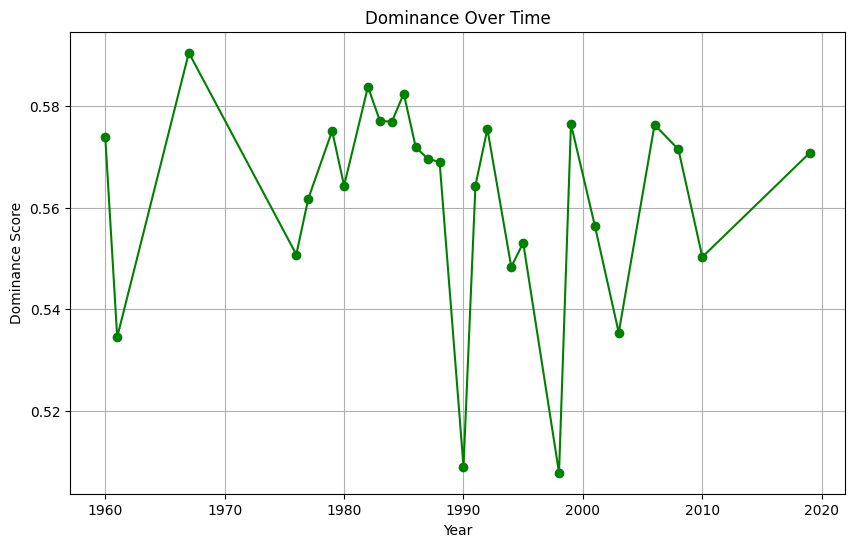

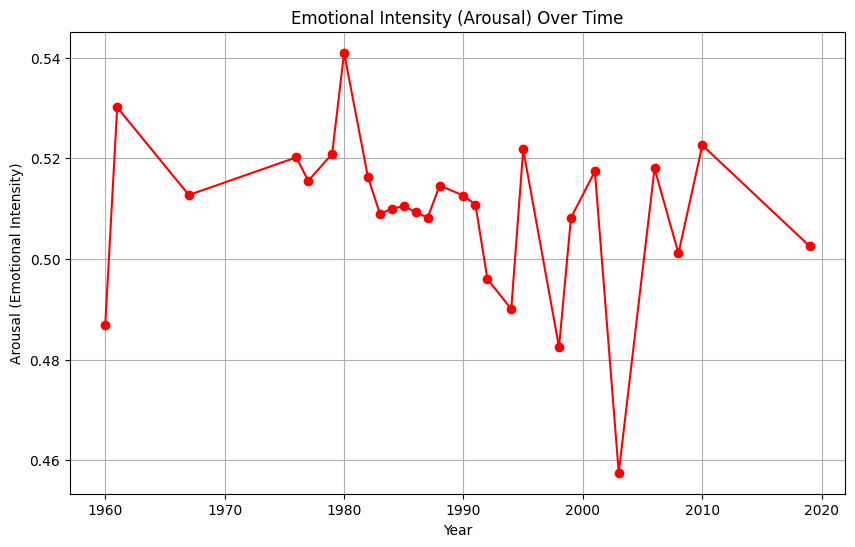

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(yearly_vad.index, yearly_vad['valence'], marker='o', color='blue')
plt.title('Valence Over Time')
plt.xlabel('Year')
plt.ylabel('Valence Score')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(yearly_vad.index, yearly_vad['dominance'], marker='o', color='green')
plt.title('Dominance Over Time')
plt.xlabel('Year')
plt.ylabel('Dominance Score')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(yearly_vad.index, yearly_vad['arousal'], marker='o', color='red')
plt.title('Emotional Intensity (Arousal) Over Time')
plt.xlabel('Year')
plt.ylabel('Arousal (Emotional Intensity)')
plt.grid(True)
plt.show()

## Statistical Validation

As per the methods section, we will now be validating the results through statistical testing, through the specific statistical tests outlined. Let us commence forth.

In [7]:
# Now we run a one-way ANOVA test on the 5-year groups to show if there are any statistically suprising differences in their average VAD scores
statistical_dataframe_even = df[(df['year'] >= 1975) & (df['year'] <= 2010)].copy()

# We create 5-year-bins as per the method
statistical_dataframe_even['five_year'] = ((statistical_dataframe_even['year'] - 1975) // 5) * 5 + 1975

# Now we shall add a bunch of Pokemon references
unova_valence = stats.f_oneway(
    *(statistical_dataframe_even[statistical_dataframe_even['five_year'] == bucket]['valence'].dropna() for bucket in sorted(statistical_dataframe_even['five_year'].unique()))
)

# ANOVA arousal (lol)
unova_arousal = stats.f_oneway(
    *(statistical_dataframe_even[statistical_dataframe_even['five_year'] == bucket]['arousal'].dropna() for bucket in sorted(statistical_dataframe_even['five_year'].unique()))
)

# ANOVA domninance 
unova_dominance = stats.f_oneway(
    *(statistical_dataframe_even[statistical_dataframe_even['five_year'] == bucket]['dominance'].dropna() for bucket in sorted(statistical_dataframe_even['five_year'].unique()))
)

# Now we make a function to prevent our results appearing as NumPy scalars
def the_prettiest_unova (label, result, decimals=3):
    f = float(result.statistic)
    p = float(result.pvalue)
    print (f"{label}:  F = {f:.{decimals}f},  p = {p:.3g}")

the_prettiest_unova("Valence ANOVA",   unova_valence)
the_prettiest_unova("Arousal ANOVA",   unova_arousal)
the_prettiest_unova("Dominance ANOVA", unova_dominance)

Valence ANOVA:  F = 7.669,  p = 3.33e-09
Arousal ANOVA:  F = 3.016,  p = 0.00369
Dominance ANOVA:  F = 6.878,  p = 3.93e-08


Our ANOVA scores have told us that in our VAD analysis, at least one result is fishy enough to investigate further. As per the method, we shall now use Tukey's HSD test to test each 5-year-block against every other block and see which ones get flagged as "I was not expecting this"!

In [8]:
# Now we shall perform Tukey's HSD to see which 5 year buckets are the very surprising ones. Please ignore my unfunny Turkey references. 

erdogan_dataframe = (
    df.assign(five_year=((df['year'] - 1975) // 5) * 5 + 1975)
      .loc[df['year'].between(1975, 2010)]
      .copy()
)

def turkey_innit(axis: str):
    m = erdogan_dataframe[axis].notna()       
    return pairwise_tukeyhsd(
        endog  = erdogan_dataframe.loc[m, axis],
        groups = erdogan_dataframe.loc[m, 'five_year'],
        alpha  = 0.05
    )

print("Tukey HSD – Valence");   print(turkey_innit('valence'))
print("\nTukey HSD – Arousal");  print(turkey_innit('arousal'))
print("\nTukey HSD – Dominance");print(turkey_innit('dominance'))

Tukey HSD – Valence
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  1975   1980   0.0123 0.2347 -0.0032  0.0278  False
  1975   1985   0.0052  0.933  -0.008  0.0184  False
  1975   1990   0.0037 0.9953 -0.0113  0.0187  False
  1975   1995  -0.0164  0.047 -0.0327 -0.0001   True
  1975   2000  -0.0072  0.996  -0.037  0.0226  False
  1975   2005   0.0106 0.3868 -0.0044  0.0255  False
  1975   2010  -0.0062    1.0 -0.0689  0.0564  False
  1980   1985  -0.0071  0.347 -0.0168  0.0027  False
  1980   1990  -0.0086 0.3791 -0.0207  0.0035  False
  1980   1995  -0.0287    0.0 -0.0423 -0.0151   True
  1980   2000  -0.0195 0.4278  -0.048  0.0089  False
  1980   2005  -0.0017 0.9999 -0.0138  0.0103  False
  1980   2010  -0.0185 0.9855 -0.0806  0.0435  False
  1985   1990  -0.0015 0.9997 -0.0105  0.0075  False
  1985   1995  -0.0216    0.0 -0.0326 -0.0106   True
  1985   2000  -0.0124 0.8

So, now we know something's going on with 1995-2000 especially. Should be interesting for our analysis. But moving on to our next step of validation. 

Now, normally, we would run a validation on if the sample size affected anything. However, 1995 was our main flag, and that was an equalish bucket to all the rest. The only flaggable buckets were 2000 and 2010, of which they did not influence the results and thus don't need to be validated, given we are not using them for any conclusion. 

Now, we need to validate something else. I recommend you take a look at the Corpus 2 code and then come back here, but as you will notice from the VAD and Corpus 2, three dinstinct eras seem to form. We now need to test the validity of these eras in Corpus 1 (as we already validated them in Corpus 2, if you recall (assuming you read it you goober!))

In [9]:
# First, we need to actually make the eras data-wise
results = {}  

def eras_upon_eras(year):
    if 1975 <= year <= 1989:
        return "Era_1"
    elif 1990 <= year <= 1999:
        return "Era_2"
    elif 2000 <= year <= 2014:
        return "Era_3"
    else:
        return "Other"

# Now we need to make a dataframe copy because apparently if we don't, Python gets angry at me (for reasons beyond my comprehension); then we can attribute our new era column
the_era_of_dataframes = df.copy()
the_era_of_dataframes['era'] = the_era_of_dataframes['year'].apply(eras_upon_eras)

def unova_pokemon_era(df, metric, eras=('Era_1', 'Era_2', 'Era_3')):
    groups = [the_era_of_dataframes[the_era_of_dataframes['era'] == era][metric].dropna() for era in eras] # This allows us to check which era we are in, and then find all the VAD scores for that era and puts them in one... pokeball if you would
    # Okay just to explain so I don't seem mentally ill, but one of the regions in Pokemon is called Unova, which sounds like ANOVA (which rhymes with Grug)
    
    f_stat, p_val = f_oneway(*groups) # This allows us to check the average of each bucket against each other and seeing if they statistically differ
    return f_stat, p_val 

# Now, we run and print it.
for metric in ['valence', 'dominance', 'arousal']:
    f_stat, p_val = unova_pokemon_era(the_era_of_dataframes, metric)
    results[metric] = (f_stat, p_val)

print(f"Valence ANOVA F-statistic:   {results['valence'][0]:.3f}")
print(f"p-value: {results['valence'][1]:.3g}\n")

print(f"Dominance ANOVA F-statistic: {results['dominance'][0]:.3f}")
print(f"p-value: {results['dominance'][1]:.3g}\n")

print(f"Arousal ANOVA F-statistic:   {results['arousal'][0]:.3f}")
print(f"p-value: {results['arousal'][1]:.3g}")

Valence ANOVA F-statistic:   10.301
p-value: 3.49e-05

Dominance ANOVA F-statistic: 13.587
p-value: 1.34e-06

Arousal ANOVA F-statistic:   0.175
p-value: 0.839


So, even in the VAD, our three-era "hypothesis" seems to be holding up, at least in Valence and Dominance. And that's great and all, but there is a larger question at play.

In Corpus 2, the era idea sort of justified itself and its own existence. We don't have that here. So while we may have justified the three eras and their boundaries in comparison to one another via VAD, we now actually need to check if their grouping as eras in the first place (so internally comparing the content of each era against itself to see if they deserve the same grouping). You know what that means.

Ash Ketchum is going back to Unova!

In [10]:
# Now we will perform an ANOVA test on each era internally. This is simple enough. Let's make a function
def unova_is_the_worst_season(df, era_label, year_range, metrics=('valence', 'dominance', 'arousal')):
    era_df = df[df['era'] == era_label]                                     

    for metric in metrics:
        year_buckets = [era_df[era_df['year'] == yr][metric].dropna()
                        for yr in year_range]
        year_buckets = [b for b in year_buckets if len(b) > 0]

        if len(year_buckets) < 2:                                          
            print(f"{era_label}  {metric}: not enough yearly data")
            continue

        f_stat, p_val = f_oneway(*year_buckets)                             
        print(f"{era_label}  {metric.capitalize()}  | | |  F = {f_stat:.3f} ,  p = {p_val:.3g}")


unova_is_the_worst_season(the_era_of_dataframes, 'Era_1', range(1975, 1990))
unova_is_the_worst_season(the_era_of_dataframes, 'Era_2', range(1990, 2000))
unova_is_the_worst_season(the_era_of_dataframes, 'Era_3', range(2000, 2015))

Era_1  Valence  | | |  F = 1.668 ,  p = 0.0827
Era_1  Dominance  | | |  F = 1.917 ,  p = 0.0389
Era_1  Arousal  | | |  F = 3.994 ,  p = 1.98e-05
Era_2  Valence  | | |  F = 7.628 ,  p = 7e-08
Era_2  Dominance  | | |  F = 5.095 ,  p = 4.19e-05
Era_2  Arousal  | | |  F = 5.364 ,  p = 2.14e-05
Era_3  Valence  | | |  F = 1.482 ,  p = 0.207
Era_3  Dominance  | | |  F = 1.898 ,  p = 0.11
Era_3  Arousal  | | |  F = 4.977 ,  p = 0.000639


Alright, and that's everything for Corpus 1. I want to point out quickly the result there, quite cheekily. TLDR, while VAD doesn't justify the existence of Era 2, its unique volatility is what defines it as an era, so the assignment is still accurate. 